Setting up environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Importing necessary libraries
import tensorflow as tf # tensorflow 2.x
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Activation, Dropout, Lambda, Conv2DTranspose, AveragePooling2D, GaussianNoise
from keras.models import Model
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import statistics
from matplotlib import pyplot as plt
import matplotlib
import time
import numpy as np
from scipy import stats
from keras import metrics
import random
import math
import pandas as pd

!pip install hic-straw
import hicstraw

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for hic-straw: filename=hic_straw-1.3.1-cp310-cp310-linux_x86_64.whl size=1616845 sha256=b9e1df9e3f4e63b6dd255d7d6595fd88450f9e53d5d24d0b589b859484b355fa
  Stored in directory: /root/.cache/pip/wheels/23/85/e0/14f1be833ddf1da34165e04938653e00b602eb93e834497ae4
Successfully built hic-straw


In [ ]:
WIDTH=10 # Size of input matrix
res=1000000 # resolution
br = matplotlib.colors.LinearSegmentedColormap.from_list("bright_red",[(1,1,1),(1,0,0)]) # color scheme
np.set_printoptions(suppress = True)
break_distance = 5*1000*1000 # Threshold for what a break is (5 MB, in this case)
folder = "Binary Classifier Training Data/"
bins = ['Type1', 'Type2', 'Type3', 'Type4', 'Type5']

In [ ]:
# Loading training files

!wget https://www.dropbox.com/s/jqbb36osbzy121r/HIC11665_PPM_HiRise_rh_HiC.hic
!wget https://www.dropbox.com/s/p1l512m2lx1zkcf/HIC12835_PPM_HiRise_rh_HiC.hic
!wget https://www.dropbox.com/s/pxa547b3dsdd8qv/Daubentonia_madagascariensis_HiC.hic
!wget https://www.dropbox.com/s/1uq0ijiiuj39wbn/Chrysocyon_brachyurus_HiC.hic
!wget https://www.dropbox.com/s/otgsb1624ohru7s/Setonix_brachyurus_HiC.hic
#!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AADEdyqNcKklsw9ihtdxds0Ja/HIC16040_canFam3.hic
!wget https://www.dropbox.com/s/igegfumda9jrlxy/primary.hic

files = ['HIC11665_PPM_HiRise_rh_HiC.hic',
         'HIC12835_PPM_HiRise_rh_HiC.hic',
         'Daubentonia_madagascariensis_HiC.hic',
         'Chrysocyon_brachyurus_HiC.hic',
         'Setonix_brachyurus_HiC.hic',
        #'HIC16040_canFam3.hic',
         'primary.hic']

# Loading testing files

!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic
testing_files = ['HIC1024_deep.hic']

--2024-08-08 15:02:51--  https://www.dropbox.com/s/jqbb36osbzy121r/HIC11665_PPM_HiRise_rh_HiC.hic
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/jqbb36osbzy121r/HIC11665_PPM_HiRise_rh_HiC.hic [following]
--2024-08-08 15:02:51--  https://www.dropbox.com/s/raw/jqbb36osbzy121r/HIC11665_PPM_HiRise_rh_HiC.hic
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9ae4b98019e35e9afe67bf82e3.dl.dropboxusercontent.com/cd/0/inline/CYTY6HwJ-JRx-ZSBCk5i-QYyPxG5CVwDYStwxot0H4mH84E5bxGV72LNHG85Hm3cjkp4-lfrHRCYrCod2ubFFIGv7IgtGXQbahyuCJiQehMsbx-M40i5u49PjXJrqAJ042jvUfRJPE_Sed_ZZ6T92ihj/file# [following]
--2024-08-08 15:02:52--  https://uc9ae4b98019e35e9afe67bf82e3.dl.dropboxusercontent.com/cd/0/inline/CYTY6HwJ-JRx-ZSBCk5i-QYyPxG5CVwDYStwxot0H4mH84

Preprocessing functions

In [ ]:
# OE functions

# Averages out each diagonal
# For symmetric matrices, return an array with the values on each diagonal replaced by the average of that diagonal
def replace_diagonal_with_average(arr):
  max_offset = arr.shape[0]
  for i in range(1, max_offset):
    np.fill_diagonal(arr[:i, max_offset-i:], np.mean(np.diagonal(arr, offset=max_offset-i)))
    np.fill_diagonal(arr[max_offset-i:, :i], np.mean(np.diagonal(arr, offset=i-max_offset)))
  np.fill_diagonal(arr, np.mean(np.diagonal(arr)))

  return arr

# Return a WIDTH * WIDTH array of a near-diagonal expected matrix

def get_expected_matrix(hic, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  expected_matrix = np.zeros([WIDTH, WIDTH])
  expected_matrices = np.zeros([sample_size, WIDTH, WIDTH])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1
  for i in range(sample_size): # Sample of matrices taken
    scaffold = int(random.random()*num_chroms)+1 # Choosing random chromosome
    chr1_start = int(random.random()*(chroms[scaffold].length//res-(WIDTH-1))) * res # Choosing random start point
    matrix = hic.getMatrixZoomData(chroms[scaffold].name, chroms[scaffold].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)
    expected_matrices[i, :, :] = replace_diagonal_with_average(matrix) # Creating expected matrix


  for i in range(WIDTH):
    for j in range(WIDTH):
      expected_matrix[i, j] = np.median(expected_matrices[:, i, j]) # Taking median of expected matrices to prevent skew from abnormal examples

  return expected_matrix

In [ ]:
# Centile Rescaling

# Capping the matrix at a certain threshold and then linearly scaling between 0 and 1

def globalPercentileProcess(matrix, threshold):
  return np.where(matrix<threshold, matrix, threshold)/threshold

# Determine numerical value for centile
# Done very similarly to get_expected_matrix function above

def get_med_threshold(hic, centiles, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  thresholds=np.zeros([len(centiles), sample_size])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1

  for i in range(sample_size):
    chrom = int(random.random()*num_chroms)+1
    chr1_start = int(random.random()*(chroms[chrom].length//res-(WIDTH-1)))
    matrix = hic.getMatrixZoomData(chroms[chrom].name, chroms[chrom].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)

    for idx, centile in enumerate(centiles):
      thresholds[idx, i] = np.percentile(matrix, centile) # Centile threshold calculated for each matrix

  final_thresholds = list()
  for i in range(len(centiles)):
    final_thresholds.append(statistics.median(thresholds[i]))

  return final_thresholds

In [ ]:
# Centiles results modifications
# Populating the middle square of the matrix with 0s

def clearSquare(arr):
  size = arr.shape[1]
  li = size//2 - size//4
  ui = size//2 + size//4
  arr[:, li:ui, li:ui, :] = 0
  return arr

# Populating the sub, sub-sub, super, super-super, and regular diagonal with 0s

def clear_diagonal(array):
  WIDTH = array.shape[1]
  diagonal_indices = np.arange(WIDTH)

  array[:, diagonal_indices, diagonal_indices, :] = 0
  array[:, diagonal_indices[1:], diagonal_indices[:-1], :] = 0
  array[:, diagonal_indices[:-1], diagonal_indices[1:], :] = 0
  array[:, diagonal_indices[2:], diagonal_indices[:-2], :] = 0
  array[:, diagonal_indices[:-2], diagonal_indices[2:], :] = 0
  return array

# Returns just the upper triangular matrix

def clearBelowDiagonal(matrix):
  observed = matrix[:, :, 0]
  modified = np.copy(matrix)
  modified[:, :, 0] = np.triu(observed)
  return modified

# OE normalization options
preprocess = lambda x: np.tanh(np.log(x))
preprocess = lambda x: np.log(x+1)
preprocess = lambda x: np.tanh(x)

Creating training, validation, and testing data

In [ ]:
# Load and normalize data to create a dataset

class DataLoader:

  def __init__(self, files, folder, bins, break_distance, res, WIDTH, modify_input = [], centiles = [], centiles_results_modified = [], oe_preprocess = []):

    self.files = files # Storing file names

    hic = []
    for i in self.files:
      hic.append(hicstraw.HiCFile(i)) # Loading hic files

    self.hic = hic
    self.folder = folder # Folder with data
    self.bins = bins # Bin names
    self.res = res # Resolution
    self.WIDTH = WIDTH # Matrix size
    self.modify_input = modify_input # Function to modify raw training data before any preprocessing
    self.centiles = centiles # Centiles to preprocess input data
    self.crm = centiles_results_modified # More preprocess methods to add to the centile processed data
    # e.g if a function to keep only the upper triangular matrix were put here, the data would consist of 1. centile processed data and
    # 2. the upper triangular matrix of the centile precessed data
    self.oep = oe_preprocess # preprocess methods on oe matrices
    self.break_distance = break_distance # threshold for what is considered a break

  def load_data(self): # Loading in all data
    all_data = []
    all_labels = []
    for f in self.files:
      file_data = []
      file_labels = []
      for bin in bins:
        arr = np.load(folder+f+"/"+bin+"_data.npy") # Loading raw training examples
        file_data.append(arr) # Storing the data from each file in a single list
        label = np.load(folder+f+"/"+bin+"_label.npy") # Loading labels
        file_labels.append(label) # Storing the labels from each file in a single list

      all_data.append(file_data) # Storing the data from all files in one big list
      all_labels.append(file_labels) # Storing the labels from all files in one big list

    self.all_data = all_data # This data will be modified with the preprocessing
    self.original_data = np.copy(all_data) # Original data that will not be modified
    self.all_labels = all_labels # This labels will be modified with the preprocessing
    self.original_labels = np.copy(all_labels) # Original labels that will not be modified

    return self

  def modify_input_data(self): # Modifying original data before primary preprocessing methods
    if self.modify_input:
      for file in range(len(self.files)):
        for bin in range(len(self.bins)):
          for idx, arr in enumerate(self.all_data[file][bin]):
            self.all_data[file][bin][idx] = self.modify_input[0](self.WIDTH, arr) # Perform the modification on each training example
    return self

  def processCentiles(self): # Centile preprocessing
    centiles_data_individual = []
    for idx, f in enumerate(self.files):
      hic = self.hic[idx]
      thresholds = get_med_threshold(hic, self.centiles, self.res, self.WIDTH) # Get centile thresholds
      data = self.all_data[idx]
      file_data = []
      for arr in data:
        centile_processed = np.zeros([arr.shape[0], self.WIDTH, self.WIDTH, len(self.centiles)])
        for i in range(len(thresholds)):
          centile_processed[:, :, :, i] = globalPercentileProcess(arr[:, :, :, 0], thresholds[i]) # Perform preprocessing
        file_data.append(centile_processed)
      centiles_data_individual.append(file_data)

    centiles_data = []
    for i in range(len(self.bins)):
      bin = [row[i] for row in centiles_data_individual]
      centiles_data.append(np.concatenate(bin, axis=0)) # Combining the same type of data from different files.


    self.centiles_data = centiles_data

    return self

  def processCentilesResultsModified(self): # More preprocessing methods on top of centile processed data
    centiles_data_modified = []
    for arr in self.centiles_data:
      modified_data = np.zeros([arr.shape[0], self.WIDTH, self.WIDTH, len(self.centiles)*len(self.crm)])
      for idx in range(len(self.crm)):
        # Applying preprocessing methods on top of centile processed data
        modified_data[:, :, :, len(self.centiles)*idx:len(self.centiles)*(idx+1)] = self.crm[idx](np.copy(arr))
      centiles_data_modified.append(modified_data)

    self.centiles_data_modified = centiles_data_modified

    return self

  def processOE(self): # Preprocess methods on oe data

    oe_data_individual = []
    for idx, f in enumerate(self.files):
      hic = self.hic[idx]
      expected_matrix = get_expected_matrix(hic, self.res, self.WIDTH) # Getting expected matrix
      data = self.all_data[idx]
      file_data = []
      for arr in data:
        oe_processed = np.zeros([arr.shape[0], self.WIDTH, self.WIDTH, len(self.oep)])
        for i in range(len(self.oep)):
          # Grabbing oe matrices and applying preprocessing methods
          temp = np.nan_to_num(np.divide(np.copy(arr[:, :, :, 0]), expected_matrix), nan=0.0)
          oe_processed[:, :, :, i] = self.oep[i](temp)
          # Replace the above 2 lines with the line below if you want to use the Juicebox values for observed/expected rather than calculating manually
          # oe_processed[:, :, :, i] = self.oep[i](np.copy(arr[:, :, :, 1]))

        file_data.append(oe_processed)
      oe_data_individual.append(file_data)

    oe_data = []
    for i in range(len(self.bins)):
      bin = [row[i] for row in oe_data_individual]
      oe_data.append(np.concatenate(bin, axis=0))

    self.oe_data = oe_data

    return self

  def combineData(self): # Combining all data
    combined_data = []
    for idx in range(len(self.centiles_data)):
      # Combining the different preprocessed results
      combined_data.append(np.concatenate([self.centiles_data[idx], self.centiles_data_modified[idx], self.oe_data[idx]], axis=-1))

    self.combined_data = combined_data

    return self

  def createLabels(self): # Creating binzarized labels
    labels = []
    for file in range(len(self.files)):
      for idx, label in enumerate(self.all_labels[file]):
          # If break distance in the example is greater than break_distance, the label is 1, meaning there is a break
          self.all_labels[file][idx] = np.where(label>break_distance, 1,0)

    for i in range(len(self.bins)):
      bin = [row[i] for row in self.all_labels]
      labels.append(np.concatenate(bin, axis=0))

    self.labels = np.concatenate(labels)

    return self

  def createDataset(self): # Combining all data to 1 final big matrix
    self.data = np.concatenate(self.combined_data)

    return self

  def run(self): # Running all the functions to generate the dataset
    self.load_data()
    self.modify_input_data()
    self.processCentiles()
    self.processCentilesResultsModified()
    self.processOE()
    self.combineData()
    self.createLabels()
    self.createDataset()

In [ ]:
training = DataLoader(files = files[:4], folder = folder, bins = bins, break_distance = break_distance, res = res, WIDTH = WIDTH, modify_input = [], centiles = [95, 90, 80], centiles_results_modified = [], oe_preprocess = [])
training.run() # Creating training data
training_data, training_labels = shuffle(training.data, training.labels)

validation = DataLoader(files = files[4:], folder = folder, bins = bins, break_distance = break_distance, res = res, WIDTH = WIDTH, modify_input = [], centiles = [95, 90, 80], centiles_results_modified = [], oe_preprocess = [])
validation.run() # Creating validation data
validation_data, validation_labels = shuffle(validation.data, validation.labels)

testing = DataLoader(files = testing_files, folder = folder, bins = bins, break_distance = break_distance, res = res, WIDTH = WIDTH, modify_input = [], centiles = [95, 90, 80], centiles_results_modified = [], oe_preprocess = [])
testing.run() # Creating testing data
testing_data, testing_labels = testing.data, testing.labels

Text(0.5, 0.98, 'Training data visualization')

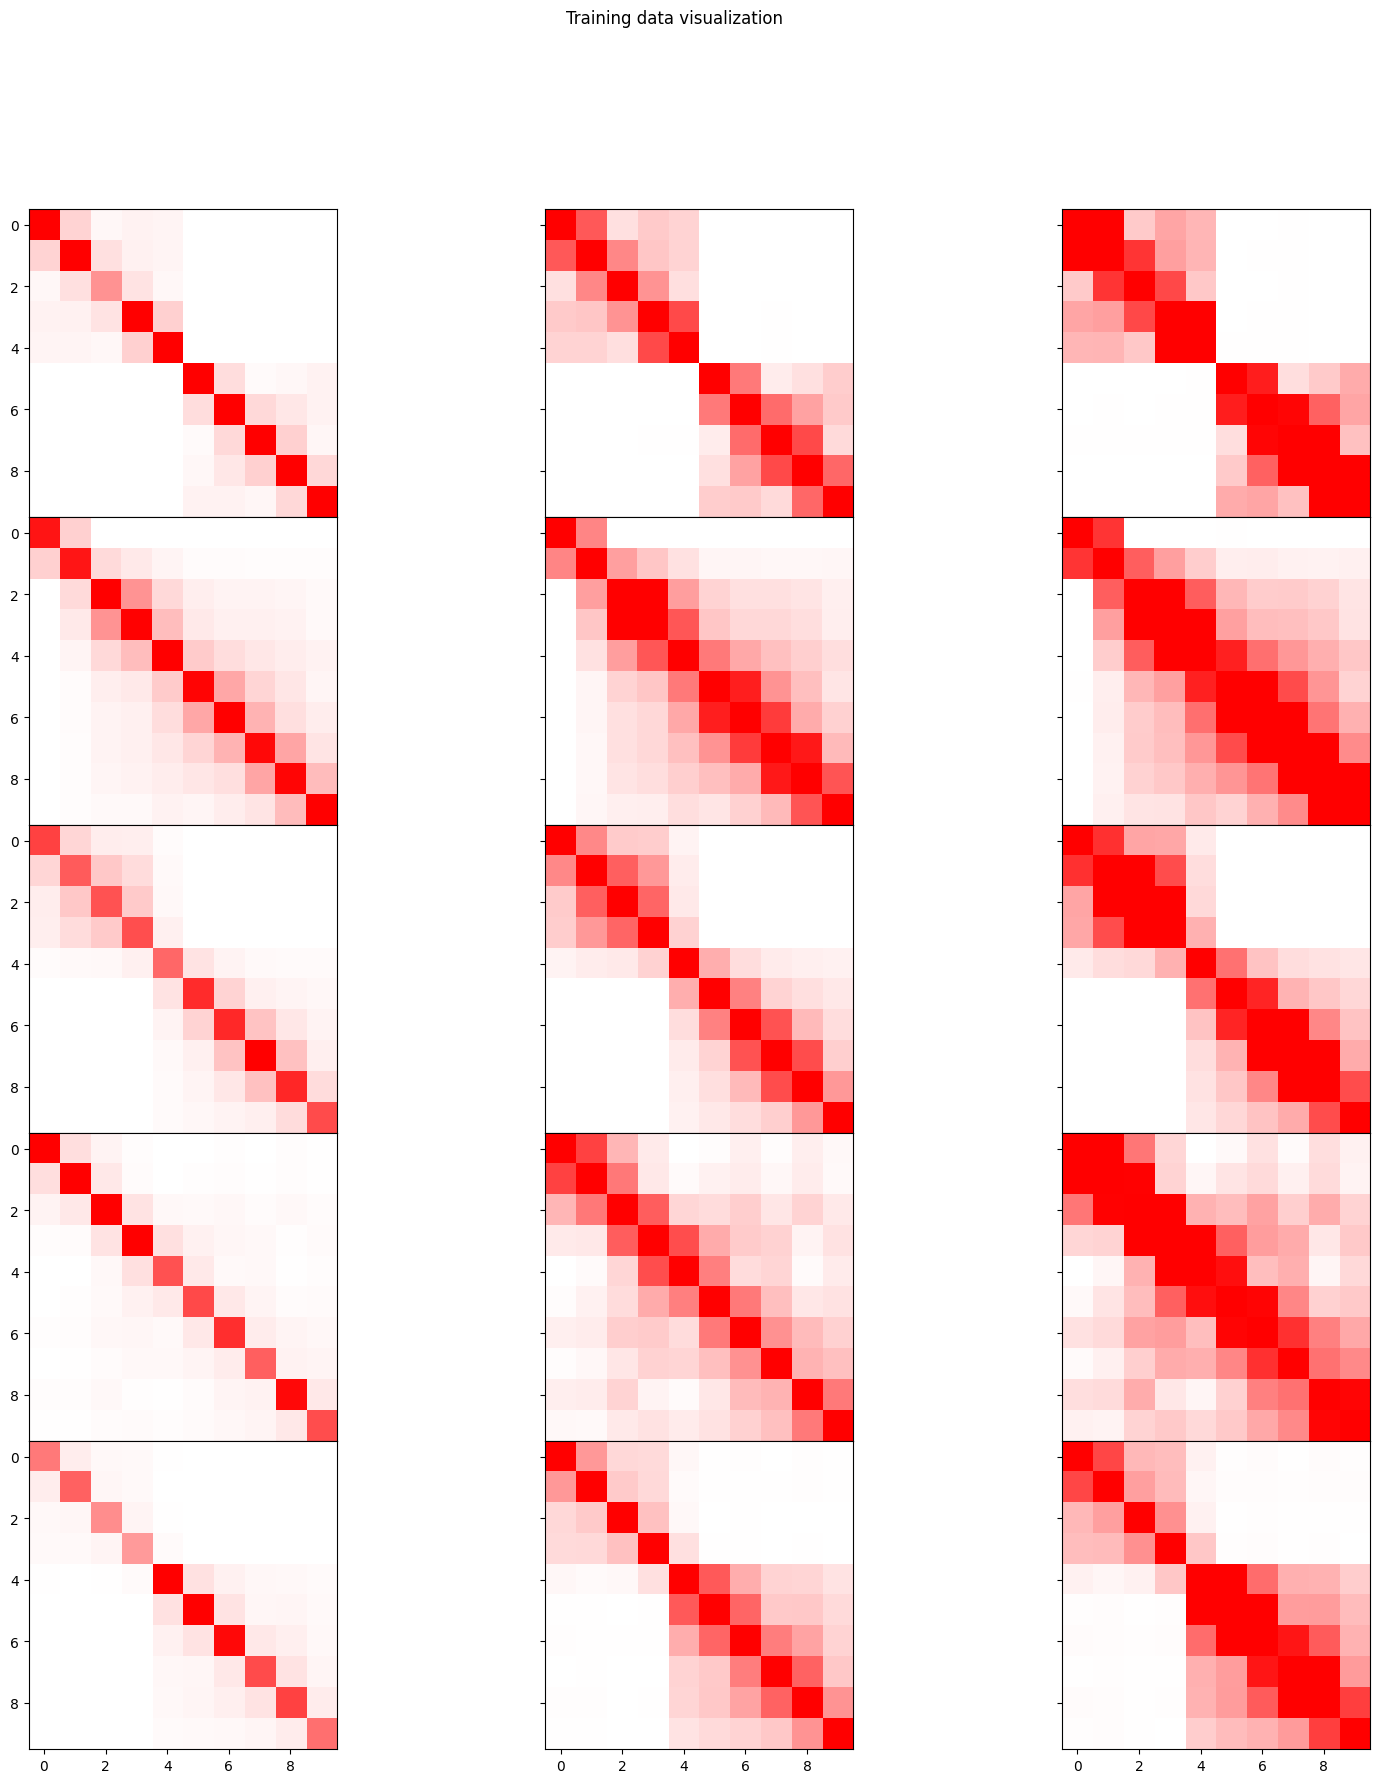

In [ ]:
# Visualizing training examples
num_examples = 5
fig, axs = plt.subplots(num_examples, training_data.shape[-1],figsize=(20, 20), sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

exmpls = random.sample(range(training_data.shape[0]), num_examples) # Choosing random examples from the training data

for i in range(num_examples):
  for j in range(training_data.shape[-1]):
    axs[i, j].imshow(training_data[exmpls[i], :, :, j], cmap=br) # Plotting training data

fig.suptitle("Training data visualization")

Building and training model

In [ ]:
# Creating model
input_img = Input(shape=(WIDTH, WIDTH, training_data.shape[-1]))
x = Conv2D(64, (10, 10), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dropout(0.2)(x) # Dropout added to prevent overfitting
x = Dense(100, activation= 'relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(1, activation= 'sigmoid', kernel_regularizer=l2(0.01))(x)
od = Model(input_img, x)

## Early stopping

early_stopping_cb=tf.keras.callbacks.EarlyStopping(monitor= "loss", patience=3,restore_best_weights=True)

od.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"]) # binary_crossentropy since there are two classes - break/no break
tf.keras.utils.plot_model(od, show_shapes=True, show_layer_activations=True) # Visualize model

# Weighting negative and postive examples so in total they influence the model equally

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(training_labels),
                                        y = training_labels
                                    )
print(class_weights)
class_weights = dict(zip(np.unique(training_labels), class_weights))

# Training model
model_hist = od.fit(
                    training_data, training_labels, epochs=10,
                    callbacks=[early_stopping_cb],
                    validation_data=(validation_data, validation_labels),
                    class_weight=class_weights,verbose=1)

[0.83333333 1.25      ]
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.7033 - loss: 1.3658 - val_accuracy: 0.8300 - val_loss: 0.5044
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8989 - loss: 0.3410 - val_accuracy: 0.9120 - val_loss: 0.3052
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9234 - loss: 0.2524 - val_accuracy: 0.9160 - val_loss: 0.2750
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9436 - loss: 0.2073 - val_accuracy: 0.9370 - val_loss: 0.2175
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9576 - loss: 0.1657 - val_accuracy: 0.9490 - val_loss: 0.1910
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9669 - loss: 0.1505 - val_accuracy: 0.9560 - val_loss: 0.1799
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9787 - loss: 0.1221 - val_accuracy: 0.9590 - val_loss: 0.1758
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9811 - loss: 0.1223 -

Evaluating model

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Best Threshold=0.495174, G-Mean=0.975, AUC = 0.997100


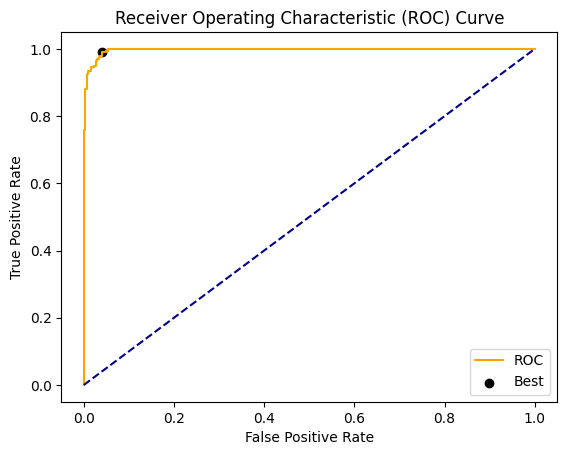

In [ ]:
# ROC curve / AUC value
preds = od.predict(testing_data)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testing_labels, preds)
auc_keras = auc(fpr_keras, tpr_keras)

gmeans = np.sqrt(tpr_keras * (1-fpr_keras))
ix = np.argmax(gmeans)

optimal_idx = np.argmax(tpr_keras - fpr_keras)
optimal_threshold = thresholds_keras[optimal_idx]
print('Best Threshold=%f, G-Mean=%.3f, AUC = %f' % (thresholds_keras[ix], gmeans[ix], auc_keras))
plt.plot(fpr_keras, tpr_keras, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.scatter(fpr_keras[ix], tpr_keras[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
class Evaluation:

  def __init__(self, model, testing_data, testing_labels, labels, best_threshold):
    self.model = model
    self.testing_data = testing_data
    self.testing_labels = testing_labels
    self.counts = np.bincount(self.testing_labels) # Count of how many examples of each class there are
    self.WIDTH = testing_data.shape[1]
    self.pm = testing_data.shape[-1] # Number of matrices in each training example (e.g. if there are just 3 centiles then self.pm = 3)
    self.labels = labels # Name of each class
    self.best_threshold = best_threshold

  def predict(self):
    self.preds = self.model.predict(self.testing_data) # predictions
    self.preds_max = np.where(self.preds>self.best_threshold, 1, 0) # determining the class from the predicted probability
    return self

  def evaluate(self):
    self.loss, self.accuracy = self.model.evaluate(self.testing_data, self.testing_labels)
    return self

  def get_confusion_matrix(self, file_name = None): # Creating confusion matrix
    self.cm = pd.DataFrame(confusion_matrix(self.testing_labels, self.preds_max))
    plt.xticks(range(len(self.labels)), self.labels, rotation=45)
    plt.yticks(range(len(self.labels)), self.labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.imshow(self.cm)

    plt.colorbar()

    if file_name: # Saving image if file_name specified
      plt.title(file_name)
      plt.savefig(file_name, bbox_inches = 'tight')

    return self

  def get_percents_of_actual_matrix(self): # Building confusion matrix with percents instead of raw numbers
    self.pam = self.cm.copy()
    for idx in range(len(self.pam)):
      self.pam.iloc[idx] = self.pam.iloc[idx]/self.counts[idx]*100

    plt.xticks(range(len(self.labels)), self.labels, rotation=45)
    plt.yticks(range(len(self.labels)), self.labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.imshow(self.pam)
    plt.colorbar()

  def visualize_examples(self, predicted, actual, max_examples=10): # To visualize examples where you can specify the actual class and what the model predicted
    examples = []
    for i in range(len(self.preds)): # Getting indexes of examples that meet the criteria
      if predicted == self.preds_max[i]:
        if actual == self.testing_labels[i]:
          examples.append(i)

    num_visualize = min(len(examples), max_examples)
    if num_visualize == 0: # In case there are no such examples
      print("There are no examples with predicted, actual =", str(predicted) +  ",", str(actual))
      return

    fig, axs = plt.subplots(num_visualize, self.pm, figsize = (self.WIDTH, self.WIDTH)) # Visualizing the examples
    for i in range(num_visualize):
      for j in range(self.pm):
        axs[i, j].imshow(self.testing_data[examples[i], :, :, j],cmap=br)

    plt.show()

In [ ]:
labels = ["No break", "Break"]
best_threshold = 0.495
evaluator = Evaluation(od, testing_data, testing_labels, labels, best_threshold)
evaluator.predict()
evaluator.evaluate()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9822 - loss: 0.1223


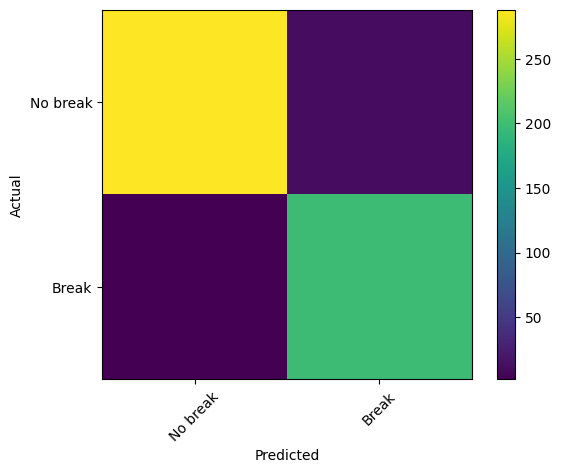

In [ ]:
evaluator.get_confusion_matrix()

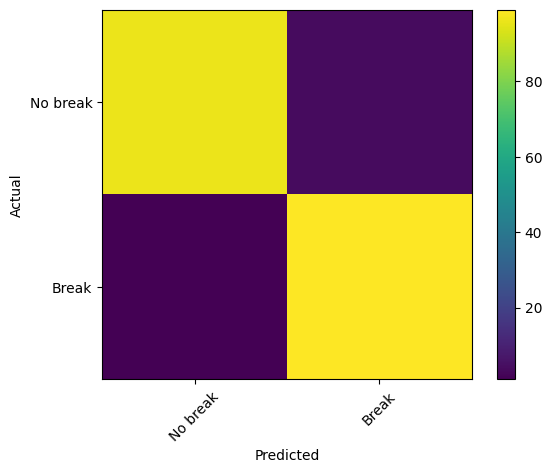

In [ ]:
evaluator.get_percents_of_actual_matrix()

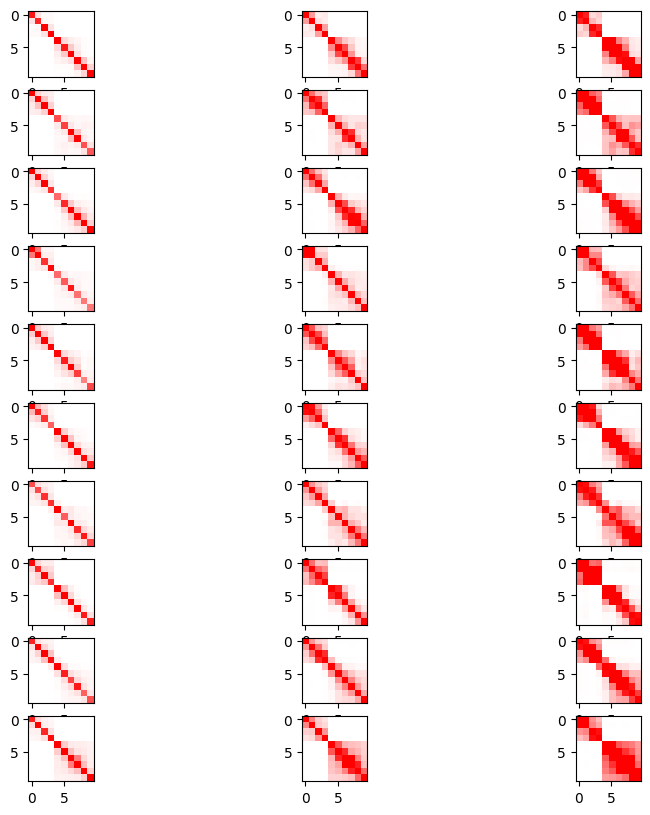

In [ ]:
evaluator.visualize_examples(predicted = 1, actual = 0)

In [ ]:
od.save('/content/drive/MyDrive/Chirag/Models/BinaryClassifier.h5') # Saving model